In [1]:
import os
import json
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42

DATA_DIR = "data"
TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
TEST_CSV = os.path.join(DATA_DIR, "test.csv")

TRAIN_IMG_DIR = os.path.join(DATA_DIR, "images", "train")
TEST_IMG_DIR = os.path.join(DATA_DIR, "images", "test")

PROCESSED_DIR = os.path.join(DATA_DIR, "processed")
os.makedirs(PROCESSED_DIR, exist_ok=True)


In [3]:
df = pd.read_csv(TRAIN_CSV)
print(df.shape)
print(df.columns)
df.info()

df.head()

(16209, 21)
Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16209 entries, 0 to 16208
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             16209 non-null  int64  
 1   date           16209 non-null  object 
 2   price          16209 non-null  int64  
 3   bedrooms       16209 non-null  int64  
 4   bathrooms      16209 non-null  float64
 5   sqft_living    16209 non-null  int64  
 6   sqft_lot       16209 non-null  int64  
 7   floors         16209 non-null  float64
 8   waterfront     16209 non-null  int64  
 9   view           16209 non-null  int64  
 10  condition      16209 non-null  int64  
 11  grade 

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,...,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,...,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,...,7,1150,90,2009,0,98027,47.5321,-122.073,1240,750
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,...,7,1280,0,1994,0,98042,47.3715,-122.074,1590,8071


In [5]:
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"])
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df.drop(columns=["date"], inplace=True)


if "sqft_living" in df.columns and "sqft_above" in df.columns and "sqft_basement" in df.columns:
    recomputed_basement = df["sqft_living"] - df["sqft_above"]
    # where official basement is 0 but recomputed > 0, fill
    mask_fix = (df["sqft_basement"] == 0) & (recomputed_basement > 0)
    df.loc[mask_fix, "sqft_basement"] = recomputed_basement[mask_fix]


In [13]:
# Example: geographic feature: distance from a reference point (approx city center)
# Take median lat/long of dataset as rough "center"
center_lat = df["lat"].median()
center_lon = df["long"].median()

def haversine_np(lat1, lon1, lat2, lon2):
    # distance in km
    R = 6371.0
    lat1_rad = np.radians(lat1)
    lat2_rad = np.radians(lat2)
    dlat = lat2_rad - lat1_rad
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

df["dist_center_km"] = haversine_np(df["lat"], df["long"], center_lat, center_lon)

# Example: log-transformed price (can use for training to stabilize)
df["log_price"] = np.log1p(df["price"])

In [9]:
#handling missing values 

# Simple missing handling: drop rows with missing target or critical columns
df = df.dropna(subset=["price", "lat", "long"])

# Identify numeric features (excluding target & id)
exclude_cols = ["id", "price", "log_price"]
numeric_features = [c for c in df.columns if df[c].dtype != "O" and c not in exclude_cols]

print("Numeric features:", numeric_features)

# Optionally remove extreme outliers in price (top 0.5%)
upper = df["price"].quantile(0.995)
df = df[df["price"] <= upper].reset_index(drop=True)


Numeric features: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year', 'month', 'dist_center_km']


In [12]:
X = df[numeric_features].values
y = df["log_price"].values  # train on log_price

X_train, X_val, y_train, y_val, train_ids, val_ids = train_test_split(
    X, y, df["id"].values, test_size=0.2, random_state=RANDOM_STATE
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("Train shape:", X_train_scaled.shape)
print("Val shape:", X_val_scaled.shape)


Train shape: (12901, 21)
Val shape: (3226, 21)


In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

y_val_pred_log = linreg.predict(X_val_scaled)
y_val_pred = np.expm1(y_val_pred_log)

y_val_true = np.expm1(y_val)

# Your sklearn version: mean_squared_error does NOT accept 'squared'
mse = mean_squared_error(y_val_true, y_val_pred)
rmse = np.sqrt(mse)

r2 = r2_score(y_val_true, y_val_pred)

print(f"Baseline Linear Regression RMSE: {rmse:.2f}, R2: {r2:.3f}")



Baseline Linear Regression RMSE: 149894.55, R2: 0.756


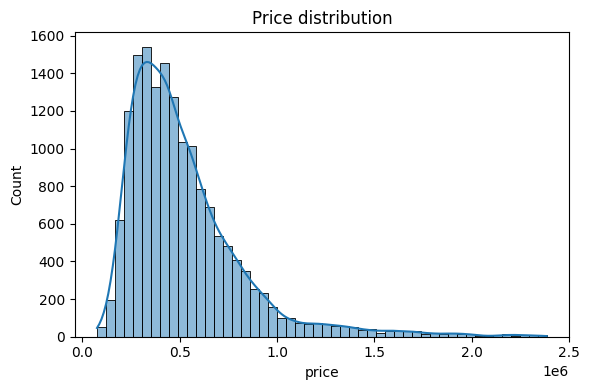

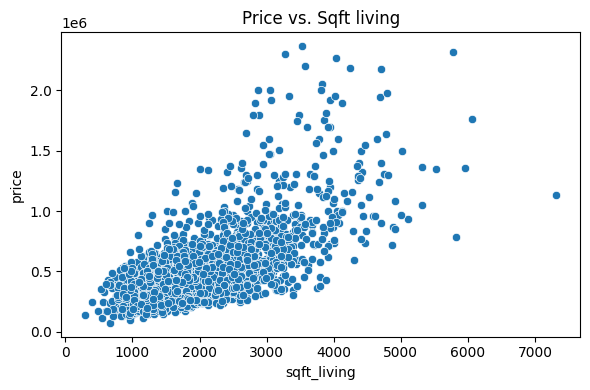

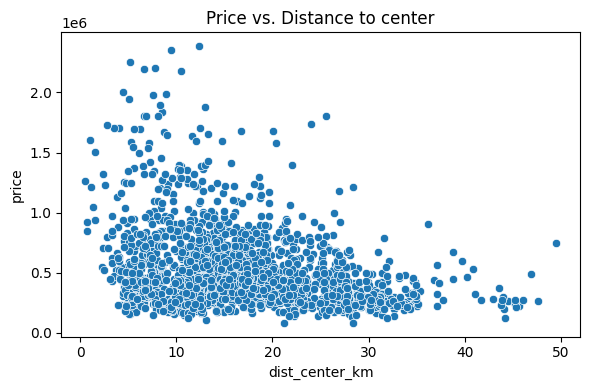

In [16]:
# Price distribution
plt.figure(figsize=(6,4))
sns.histplot(df["price"], bins=50, kde=True)
plt.title("Price distribution")
plt.tight_layout()
plt.show()

# Relationship: price vs sqft_living
plt.figure(figsize=(6,4))
sns.scatterplot(x="sqft_living", y="price", data=df.sample(min(2000, len(df))))
plt.title("Price vs. Sqft living")
plt.tight_layout()
plt.show()

# Relationship: price vs dist_center_km
plt.figure(figsize=(6,4))
sns.scatterplot(x="dist_center_km", y="price", data=df.sample(min(2000, len(df))))
plt.title("Price vs. Distance to center")
plt.tight_layout()
plt.show()


In [17]:
# Save numpy arrays
np.save(os.path.join(PROCESSED_DIR, "X_train_tabular.npy"), X_train_scaled)
np.save(os.path.join(PROCESSED_DIR, "X_val_tabular.npy"), X_val_scaled)
np.save(os.path.join(PROCESSED_DIR, "y_train_log_price.npy"), y_train)
np.save(os.path.join(PROCESSED_DIR, "y_val_log_price.npy"), y_val)
np.save(os.path.join(PROCESSED_DIR, "train_ids.npy"), train_ids)
np.save(os.path.join(PROCESSED_DIR, "val_ids.npy"), val_ids)

# Save scaler
import joblib
joblib.dump(scaler, os.path.join(PROCESSED_DIR, "tabular_scaler.joblib"))

# Metadata JSON for later use in model_training
meta = {
    "numeric_features": numeric_features,
    "target": "log_price",
    "center_lat": float(center_lat),
    "center_lon": float(center_lon),
    "train_img_dir": TRAIN_IMG_DIR,
    "test_img_dir": TEST_IMG_DIR,
}
with open(os.path.join(PROCESSED_DIR, "metadata.json"), "w") as f:
    json.dump(meta, f, indent=2)

print("Saved processed tabular data and metadata.")


Saved processed tabular data and metadata.


In [18]:
df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,dist_center_km,log_price
0,9117000170,268643,4,2.25,1810,9240,2.0,0,0,3,...,0,98055,47.4362,-122.187,1660,9240,2015,5,15.430989,12.501142
1,6700390210,245000,3,2.50,1600,2788,2.0,0,0,4,...,0,98031,47.4034,-122.187,1720,3605,2014,7,19.012892,12.409018
2,7212660540,200000,4,2.50,1720,8638,2.0,0,0,3,...,0,98003,47.2704,-122.313,1870,7455,2015,1,34.101864,12.206078
3,8562780200,352499,2,2.25,1240,705,2.0,0,0,3,...,0,98027,47.5321,-122.073,1240,750,2015,4,12.586214,12.772806
4,7760400350,232000,3,2.00,1280,13356,1.0,0,0,3,...,0,98042,47.3715,-122.074,1590,8071,2014,12,25.180083,12.354497


In [22]:
# ==========================================
# TABULAR BASELINE (right here in preprocessing!)
# ==========================================

import joblib
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

print(" TRAINING TABULAR BASELINE...")

# Load data you just saved
X_train = np.load(os.path.join(PROCESSED_DIR, "X_train_tabular.npy"))
X_val = np.load(os.path.join(PROCESSED_DIR, "X_val_tabular.npy"))
y_train = np.load(os.path.join(PROCESSED_DIR, "y_train_log_price.npy"))
y_val = np.load(os.path.join(PROCESSED_DIR, "y_val_log_price.npy"))

scaler = joblib.load(os.path.join(PROCESSED_DIR, "tabular_scaler.joblib"))
with open(os.path.join(PROCESSED_DIR, "metadata.json")) as f:
    meta = json.load(f)

print(f"Data loaded: Train={X_train.shape[0]}, Val={X_val.shape[0]}")

# Train
model = GradientBoostingRegressor(n_estimators=300, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Validate
y_pred_log = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(y_pred_log)))
r2 = r2_score(np.expm1(y_val), np.expm1(y_pred_log))

print(f" TABULAR BENCHMARK:")
print(f"   RMSE: {rmse:.0f}")
print(f"   R²:   {r2:.3f}")

# Save model
os.makedirs("models", exist_ok=True)
joblib.dump(model, "models/tabular_baseline.joblib")
print(" Model saved: models/tabular_baseline.joblib")

# Test submission
print("\n Test predictions...")
test_df = pd.read_csv("data/test.csv")
numeric_features = meta["numeric_features"]

# Feature engineering to match
if "date" in test_df.columns:
    test_df["date"] = pd.to_datetime(test_df["date"])
    test_df["year"] = test_df["date"].dt.year
    test_df["month"] = test_df["date"].dt.month
    test_df.drop("date", axis=1, inplace=True)

test_df["dist_center_km"] = haversine_np(test_df["lat"], test_df["long"], meta["center_lat"], meta["center_lon"])
X_test = test_df[numeric_features].ffill().bfill().values
X_test_scaled = scaler.transform(X_test)

test_pred_log = model.predict(X_test_scaled)
test_pred = np.expm1(test_pred_log)

submission = pd.DataFrame({"id": test_df["id"], "predicted_price": test_pred})
submission.to_csv("submission_tabular.csv", index=False)
print(" TABULAR SUBMISSION: submission_tabular.csv")
print(f"   Predictions: ${test_pred.min():.0f} - ${test_pred.max():.0f}")

print("\n TABULAR BASELINE COMPLETE!")
print("Next: model_training.ipynb for multimodal!")


🎯 TRAINING TABULAR BASELINE...
Data loaded: Train=12901, Val=3226
✅ TABULAR BENCHMARK:
   RMSE: 101496
   R²:   0.888
✅ Model saved: models/tabular_baseline.joblib

🔮 Test predictions...
✅ TABULAR SUBMISSION: submission_tabular.csv
   Predictions: $103489 - $3020213

🎉 TABULAR BASELINE COMPLETE!
Next: model_training.ipynb for multimodal!


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16127 entries, 0 to 16126
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              16127 non-null  int64  
 1   price           16127 non-null  int64  
 2   bedrooms        16127 non-null  int64  
 3   bathrooms       16127 non-null  float64
 4   sqft_living     16127 non-null  int64  
 5   sqft_lot        16127 non-null  int64  
 6   floors          16127 non-null  float64
 7   waterfront      16127 non-null  int64  
 8   view            16127 non-null  int64  
 9   condition       16127 non-null  int64  
 10  grade           16127 non-null  int64  
 11  sqft_above      16127 non-null  int64  
 12  sqft_basement   16127 non-null  int64  
 13  yr_built        16127 non-null  int64  
 14  yr_renovated    16127 non-null  int64  
 15  zipcode         16127 non-null  int64  
 16  lat             16127 non-null  float64
 17  long            16127 non-null 

In [24]:
df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,dist_center_km,log_price
0,9117000170,268643,4,2.25,1810,9240,2.0,0,0,3,...,0,98055,47.4362,-122.187,1660,9240,2015,5,15.430989,12.501142
1,6700390210,245000,3,2.50,1600,2788,2.0,0,0,4,...,0,98031,47.4034,-122.187,1720,3605,2014,7,19.012892,12.409018
2,7212660540,200000,4,2.50,1720,8638,2.0,0,0,3,...,0,98003,47.2704,-122.313,1870,7455,2015,1,34.101864,12.206078
3,8562780200,352499,2,2.25,1240,705,2.0,0,0,3,...,0,98027,47.5321,-122.073,1240,750,2015,4,12.586214,12.772806
4,7760400350,232000,3,2.00,1280,13356,1.0,0,0,3,...,0,98042,47.3715,-122.074,1590,8071,2014,12,25.180083,12.354497
